# Hydrogen Molecule Simulation

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm
from qiskit.providers.ibmq import least_busy

from qiskit.aqua import QuantumInstance
from qiskit.aqua.algorithms import ExactEigensolver, VQE
from qiskit.aqua.components.variational_forms import RYRZ
from qiskit.aqua.components.optimizers import SPSA, COBYLA
from qiskit.providers.aer.noise import NoiseModel
from qiskit import IBMQ, Aer

from time import time

from H2_helpers import *

## Exact Theoretical Approach

Here we find the exact bond energy of the H2 molecule at the bond length of 0.735 Angstroms or 7.35x10$^{-2}$ nm, where the molecule is most stable.

In [16]:
bond_length= 0.735
qubit_op, operator= get_H2_Hamiltonian(bond_length)
result = NumPyMinimumEigensolver(qubit_op).run()
exact_result = operator.process_algorithm_result(result)

print('========= Ground State Energy =========')
print('Total Energy (Hartree): {:.10f}'.format(exact_result.energy))
print('Electronic Energy (Hartree): {:.10f}'.format(exact_result.electronic_energy))
print('Nuclear Repulsion Energy (Hartree): {:.10f}'.format(exact_result.nuclear_repulsion_energy))

========= Ground State Energy =========
Total Energy (Hartree): -1.1373060358
Electronic Energy (Hartree): -1.8572750270
Nuclear Repulsion Energy (Hartree): 0.7199689913


Now lets find the bond energy of the H2 molecule at different bond lengths. Plot the total energy vs. bond length. Also compare how the electronic energy changes with how the nuclear repulsion energy changes with bond length

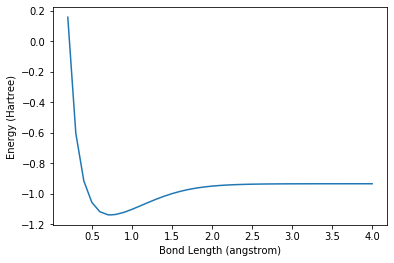

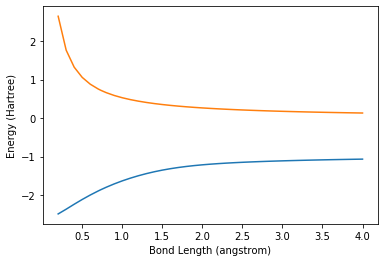

In [4]:
bond_lengths= sorted(list(np.arange(0.2, 4.1, 0.1))+[0.735])
theory_energies=[]
theory_electronic_energies=[]
theory_nuclear_repulsion=[]

for a in tqdm(bond_lengths):
    qubit_op, operator= get_H2_Hamiltonian(a)
    result = NumPyMinimumEigensolver(qubit_op).run()
    result = operator.process_algorithm_result(result)
    theory_energies.append(result.energy)
    theory_electronic_energies.append(result.electronic_energy)
    theory_nuclear_repulsion.append(result.nuclear_repulsion_energy)

plt.plot(bond_lengths, theory_energies)
plt.ylabel('Energy (Hartree)')
plt.xlabel('Bond Length (angstrom)')
plt.show()

plt.plot(bond_lengths, theory_electronic_energies)
plt.plot(bond_lengths, theory_nuclear_repulsion)

plt.ylabel('Energy (Hartree)')
plt.xlabel('Bond Length (angstrom)')
plt.show()

## Variational Quantum Eigensolver (VQE) approach

Let's use a hybrid quantum-classical algorithm to find the bond energy of H2.

### Noiseless

Here, we use a variational quantum algorithm to find the energy of the H2 molecule at it's most stable bond length (0.735 A) using a noiseless quantum simulator.

We start by using an RYRZ variational circuit: https://qiskit.org/documentation/stubs/qiskit.aqua.components.variational_forms.RYRZ.html
with depth 5.

We optimize our quantum circuit using a Simultaneous Perturbation Stochastic Approximation (SPSA) optimizer: https://qiskit.org/documentation/stubs/qiskit.aqua.components.optimizers.SPSA.html

In [4]:
bond_length= 0.735
qubit_op, operator= get_H2_Hamiltonian(bond_length)
t0=time()
var_form = RYRZ(qubit_op.num_qubits, depth=5, entanglement='full')
optimizer = SPSA()
simulator = Aer.get_backend('qasm_simulator')
algo = VQE(qubit_op, var_form, optimizer)
result = algo.run(QuantumInstance(simulator))

result = operator.process_algorithm_result(result)
print('========= Ground State Energy =========')
print('Total Energy (Hartree): {:.10f}'.format(result.energy))
print('Electronic Energy (Hartree): {:.10f}'.format(result.electronic_energy))
print('Nuclear Repulsion Energy (Hartree): {:.10f}'.format(result.nuclear_repulsion_energy))
print(time()-t0)

========= Ground State Energy =========
Total Energy (Hartree): -1.1373038348
Electronic Energy (Hartree): -1.8572728260
Nuclear Repulsion Energy (Hartree): 0.7199689913
36.69575357437134


Now let's explore what happens if we vary the variational circuit depth. Plot the output energy of VQE algorithm vs. circuit depth. Can you explain your observation? 

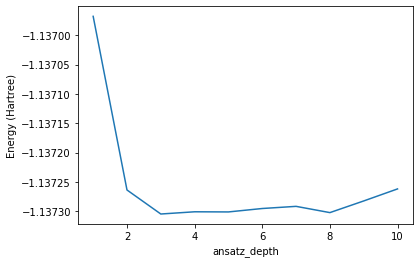

In [7]:
circuit_depths=np.linspace(1,10,10)

depth_energy=[]

for depth in tqdm(circuit_depths):
    var_form = RYRZ(qubit_op.num_qubits, depth=int(depth), entanglement='full')
    optimizer = SPSA()
    simulator = Aer.get_backend('qasm_simulator')
    algo = VQE(qubit_op, var_form, optimizer)
    result = algo.run(QuantumInstance(simulator))
    result = operator.process_algorithm_result(result)
    depth_energy.append(result.energy)
    
plt.plot(circuit_depths, depth_energy)
plt.ylabel('Energy (Hartree)')
plt.xlabel('ansatz_depth')
plt.show()

Next, find the energy of the H2 molecule for a few different bond lengths using VQE and plot them against the exact solutions computed earlier.

In [8]:
ideal_vqe_energies= []
vqe_bond_lengths= bond_lengths[::2]
depth=3 #Change

for a in tqdm(vqe_bond_lengths):
    qubit_op, operator= get_H2_Hamiltonian(a)
    var_form = RYRZ(qubit_op.num_qubits, depth=depth, entanglement='full')
    optimizer = SPSA()
    simulator = Aer.get_backend('qasm_simulator')
    algo = VQE(qubit_op, var_form, optimizer)
    result = algo.run(QuantumInstance(simulator))
    result = operator.process_algorithm_result(result)
    ideal_vqe_energies.append(result.energy)

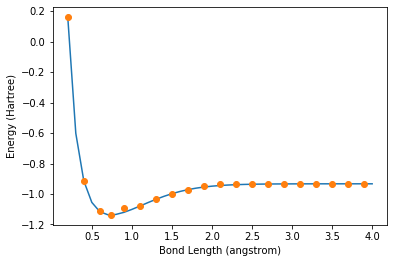

In [71]:
plt.plot(bond_lengths, theory_energies)
plt.plot(bond_lengths[::2], ideal_vqe_energies,'o')
plt.ylabel('Energy (Hartree)')
plt.xlabel('Bond Length (angstrom)')
plt.show()

### Noisy simulation

The quantum computers that we have access to today are noisy systems, and the noise could change the output of our quantum algorithm. In this section we will add a noise component to our quantum simulation. You can find more information about different noise models here: https://qiskit.org/documentation/apidoc/aer_noise.html

In [13]:
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q-education', group='tcs-karamlou', project='summer-2020')
backend = least_busy(provider.backends())
print(backend)
noise_model = NoiseModel.from_backend(backend)

ibmqfactory.load_account:WARNING:2020-07-17 14:52:45,969: Credentials are already in use. The existing account in the session will be replaced.


ibmq_valencia


In [15]:
bond_length= 0.735
qubit_op, operator= get_H2_Hamiltonian(bond_length)

var_form = RYRZ(qubit_op.num_qubits, depth=3, entanglement='full')
optimizer = SPSA()
simulator = Aer.get_backend('qasm_simulator')
algo = VQE(qubit_op, var_form, optimizer)
result = algo.run(QuantumInstance(simulator), NoiseModel=noise_model) # We add the noise model here

result = operator.process_algorithm_result(result)
print('========= Ground State Energy =========')
print('Total Energy (Hartree): {:.10f}'.format(result.energy))
print('Electronic Energy (Hartree): {:.10f}'.format(result.electronic_energy))
print('Nuclear Repulsion Energy (Hartree): {:.10f}'.format(result.nuclear_repulsion_energy))

========= Ground State Energy =========
Total Energy (Hartree): -1.1373046014
Electronic Energy (Hartree): -1.8572735927
Nuclear Repulsion Energy (Hartree): 0.7199689913


Now check how the quantum algorithm performance changes by varying the depth. Plot the calculated energy values when varying the algorithm depth and choose the best depth. Note that we need the energy to be accurate to 0.001 Hartree for a successful simulation. 

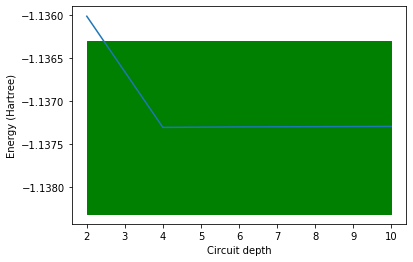

In [18]:
depths=np.linspace(2,10,5)

depth_energy=[]

for depth in tqdm(depths):
    var_form = RYRZ(qubit_op.num_qubits, depth=int(depth), entanglement='full')
    optimizer = SPSA()
    simulator = Aer.get_backend('qasm_simulator')
    algo = VQE(qubit_op, var_form, optimizer)
    result = algo.run(QuantumInstance(simulator), NoiseModel=noise_model)
    result = operator.process_algorithm_result(result)
    depth_energy.append(result.energy)

plt.plot(depths, depth_energy)
plt.fill_between(depths, exact_result.energy-0.001, exact_result.energy+0.001, color='green')
plt.ylabel('Energy (Hartree)')
plt.xlabel('Circuit depth')
plt.show()

Next, find the energy of the H2 molecule for a few different bond lengths using VQE with a noise model of a real quantum hardware and plot them against the exact solutions computed earlier.

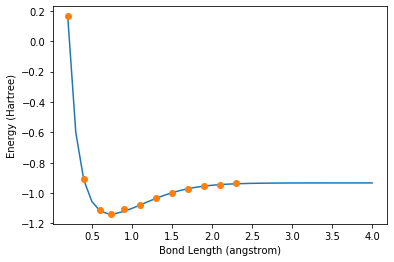

In [75]:
noisy_vqe_energies= []
noisy_vqe_bond_lengths= vqe_bond_lengths[:12]
depth=1 #Change

for a in tqdm(noisy_vqe_bond_lengths):
    qubit_op, operator= get_H2_Hamiltonian(a)
    var_form = RYRZ(qubit_op.num_qubits, depth=depth, entanglement='full')
    optimizer = SPSA()
    simulator = Aer.get_backend('qasm_simulator')
    algo = VQE(qubit_op, var_form, optimizer)
    result = algo.run(QuantumInstance(simulator), NoiseModel=noise_model)
    result = operator.process_algorithm_result(result)
    noisy_vqe_energies.append(result.energy)
    
plt.plot(bond_lengths, theory_energies)
plt.plot(noisy_vqe_bond_lengths, noisy_vqe_energies,'o')
plt.ylabel('Energy (Hartree)')
plt.xlabel('Bond Length (angstrom)')
plt.show()

### Quantum device

In [90]:
provider = IBMQ.load_account()
backend = least_busy(provider.backends())
print(backend)
noise_model = NoiseModel.from_backend(backend)

ibmqfactory.load_account:WARNING:2020-06-12 17:31:09,214: Credentials are already in use. The existing account in the session will be replaced.


First, let's train our circuit using a simulator

In [102]:
depth=1 #Change

bond_length= 0.735
qubit_op, operator= get_H2_Hamiltonian(bond_length)

var_form = RYRZ(qubit_op.num_qubits, depth=depth, entanglement='full')
optimizer = SPSA()
simulator = Aer.get_backend('qasm_simulator')
algo = VQE(qubit_op, var_form, optimizer)
simulation_result = algo.run(QuantumInstance(simulator), NoiseModel=noise_model)

{'optimal_parameters': {Parameter(θ[0]): -0.9426989980600082, Parameter(θ[1]): -3.141449745527221, Parameter(θ[2]): -2.920512083821462, Parameter(θ[3]): 1.637838159404548, Parameter(θ[4]): -2.2289495900375025, Parameter(θ[5]): -1.6227082869210443, Parameter(θ[6]): 3.1501421652232624, Parameter(θ[7]): 0.03442803881707625}, 'optimal_point': array([-0.942699  , -3.14144975, -2.92051208,  1.63783816, -2.22894959,
       -1.62270829,  3.15014217,  0.03442804]), 'optimal_value': -1.85311958725201, 'optimizer_time': 8.143986225128174, 'eigenvalue': (-1.85311958725201+0j), 'eigenstate': {'01': 1004, '11': 6, '10': 14}, 'cost_function_evals': 2051}

Now, let's run the optimal circuit on an actual quantum computer!

In [108]:
optimal_point= simulation_result['optimal_point']
algo = VQE(qubit_op, var_form, COBYLA(1),initial_point=optimal_point)
hardware_result = algo.run(backend)#, shots=8192)
hardware_result = operator.process_algorithm_result(hardware_result)

print('========= Ground State Energy =========')
print('Total Energy (Hartree): {:.10f}'.format(hardware_result.energy))
print('Electronic Energy (Hartree): {:.10f}'.format(hardware_result.electronic_energy))
print('Nuclear Repulsion Energy (Hartree): {:.10f}'.format(hardware_result.nuclear_repulsion_energy))

The skip Qobj validation does not work for IBMQ provider. Disable it.


========= Ground State Energy =========
Total Energy (Hartree): -1.0641853726
Electronic Energy (Hartree): -1.7841543639
Nuclear Repulsion Energy (Hartree): 0.7199689913
